# Setup

In [31]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

In [32]:
import tensorflow as tf
import pandas as pd
import numpy as np
import json
from utils.char_tokenizer import CharTokenizer

In [33]:
if tf.config.list_physical_devices('GPU'):
    tf.config.experimental.get_memory_info("GPU:0")

In [34]:
config = json.load(open("config.json"))

# Downloading and preprocessing data

In [8]:
from utils.data_loader import download_abo, preprocess_data

In [4]:
download_abo(config["data"]["path"])

100%|██████████| 83.4M/83.4M [00:04<00:00, 21.4MB/s]


100%|██████████| 3.03G/3.03G [02:18<00:00, 23.5MB/s] 


Extracting listings...
Extracting images...
Done


In [10]:
preprocess_data(config["data"]["path"], alt_augment=False, random_deletion=False)

Loading images...
Loading texts...
Importing listings CSV...
Creating ground truth...
Merging images and texts...
Creating false samples/complement...
Merging ground truth and complement...
Concatenating attributes into description columns...
Finishing up...


/home/azureuser/localfiles/multimodal_product_matching/utils/data_loader.py:143: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset_final["description"] = dataset_final['description'].str.replace(r'[^\x00-\x7F]+', '')
/home/azureuser/localfiles/multimodal_product_matching/utils/data_loader.py:144: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset_final["description2"] = dataset_final['description2'].str.replace(r'[^\x00-\x7F]+', '')


Exporting to CSV...
Done


In [35]:
data = pd.read_csv(os.path.join(config["data"]["path"], "data.csv"))
data = data.drop({"Unnamed: 0"}, axis=1)
data = data[['description', 'path', 'product_type', 'label']]
data

,description,path,product_type,label
0,replacement brush headsb074md2l3mamazon brand ...,09/092e7f72.jpg,SANDAL,0
1,back coverb0857lqjhlamazon essentials women's ...,6f/6f712026.jpg,AUTO_OIL,0
2,ottomansb074h5j9pkthe fix vail choked-up banan...,2c/2ccce6cf.jpg,CELLULAR_PHONE_CASE,0
3,mobile coverb07th325hkamazonbasics patio squar...,52/5233839c.jpg,LIGHT_BULB,0
4,mobile coverb07tbv1x82amazon brand - solimo de...,8c/8c190d2f.jpg,CELLULAR_PHONE_CASE,1
...,...,...,...,...
157098,mobile coverb07t8q1f1mamazon brand - solimo de...,41/417b1c42.jpg,CELLULAR_PHONE_CASE,1
157099,bedb0825cxg8hamazon brand rivet mid-century m...,a8/a893b327.jpg,LAMP,1
157100,cowb0853wvft7amazon brand - solimo designer lo...,9a/9a915a1c.jpg,CELLULAR_PHONE_CASE,0
157101,mobile coverb07tbv3mlwamazon brand - solimo de...,df/df57bd04.jpg,CELLULAR_PHONE_CASE,1


In [36]:
img = data[["path"]] # two brackets for keeping the column name
text = data["description"]
product_types = data[["product_type"]]
labels = data[["label"]]

# Text processing

## Tokenize texts

In [37]:
tk = CharTokenizer(config["data"]["alphabet"])
text = tk.tokenize(text)
text.shape

(157103, 1014)

## Create embedding weights

In [38]:
weights = tk.create_embedding_weights()
weights.shape

(70, 69)

# Image processing

## Load image model

In [39]:
from utils import img_models

In [40]:
img_model = img_models.load(config["img_model"])

img_model.output_shape

(None, 576)

## Create image embeddings

In [11]:
img = img_models.create_embeddings_from(img_model, img, os.path.join(config["data"]["path"], "images/small"))

Found 157215 validated image filenames.


2023-05-23 13:41:52.528294: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8204


In [12]:
img.shape

(157215, 576)

# Save embeddings

In [41]:
save_path = os.path.join(config["data"]["path"], "embeddings")

In [14]:
os.makedirs(save_path, exist_ok=True)
np.save(f"{save_path}/img.npy", img)
np.save(f"{save_path}/text.npy", text)
data.to_csv(f"{save_path}/data.csv")

## Verify import

In [42]:
data = pd.read_csv(f"{save_path}/data.csv")
data = data.drop({"Unnamed: 0"}, axis=1)
data

,description,path,product_type,label
0,mobile coverb07bhgv3hwamazon brand - solimo de...,b1/b1ba0ec7.jpg,SHOES,0
1,b07t8pz6tdamazonbasics led (a19 a21) (),91/91c0d7f1.jpg,CELLULAR_PHONE_CASE,0
2,b07pfx87fkamazonbasics 3 liter electr...,ef/ef536229.jpg,SHOES,0
3,"poco x2 360 coverb07q4v7bj4365 everyday value,...",db/db3abf58.jpg,OFFICE_PRODUCTS,0
4,mobile coverb07th3ccmsamazon brand - solimo de...,e2/e2b76a6d.jpg,CELLULAR_PHONE_CASE,1
...,...,...,...,...
157210,"smallb01ewf5abwfresh prepared, apple butter, d...",53/53306ecc.jpg,GROCERY,0
157211,mobile coverb07thslpsjamazon brand - solimo de...,6a/6aed6cae.jpg,CELLULAR_PHONE_CASE,1
157212,farmhouseb07dtffjs5rivet mid-century modern tw...,45/45aa7bd8.jpg,LIGHT_FIXTURE,1
157213,mobile coverb07tg3tvsvamazon brand - solimo de...,c9/c9d2a769.jpg,CELLULAR_PHONE_CASE,1


In [43]:
img = np.load(f"{save_path}/img.npy")
img.shape

(157215, 576)

In [44]:
text = np.load(f"{save_path}/text.npy")
text.shape

(157215, 1014)

# Train-Test Split

To use `stratify` parameter of `sklearn.model_selection.train_test_split()`, we need to select all product instances which appear more than once

In [45]:
data["product_type_count"] = data.groupby(["product_type"])["product_type"].transform("count")

data = data[data["product_type_count"] > config["data"]["cls"]]

In [46]:
# Update both columns
product_types = data[["product_type"]]

labels = data[["label"]]

In [47]:
from sklearn.model_selection import train_test_split

In [48]:
train, test, labels_train, labels_test = train_test_split(data, labels, stratify=product_types, test_size=config["mnn_em"]["training"]["test_split"], random_state=42)

In [49]:
img_train = img[train.index]
img_test = img[test.index]

text_train = text[train.index]
text_test = text[test.index]

# Save Char CNN config

In [50]:
from models.char_cnn_zhang import CharCNNZhang

In [51]:
char_cnn_config = {
    "input_size": config["data"]["input_size"],
    "embedding_size": len(tk.word_index),
    "conv_layers": config["char_cnn_zhang"]["conv_layers"],
    "fc_layers": config["char_cnn_zhang"]["fc_layers"],
    "output_size": config["char_cnn_zhang"]["output_size"],
    "embedding_weights": weights
}

In [52]:
# txt_model = CharCNNZhang(**char_cnn_config)

# Build MNN-EM Model

In [53]:
from models.mnn_em import MNNEM
from utils.eval import create_metrics

In [54]:
mnn_em = MNNEM(
    img_input_size=img_model.layers[-1].output_shape[1],
    txt_input_size=config["data"]["input_size"],
    txt_weights=weights,
    char_cnn_config=char_cnn_config,
    fc_layers=config["mnn_em"]["fc_layers"],
    combined_fc_layers=config["mnn_em"]["combined_fc_layers"],
    learning_rate=config["mnn_em"]["training"]["learning_rate"],
    metrics=create_metrics(config["mnn_em"]["training"]["metrics"]))

In [55]:
mnn_em.model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Text_Input (InputLayer)        [(None, 1014)]       0           []                               
                                                                                                  
 Image_Input (InputLayer)       [(None, 576)]        0           []                               
                                                                                                  
 Character_Level_CNN (Functiona  (None, 2048)        13437918    ['Text_Input[0][0]']             
 l)                                                                                               
                                                                                                  
 Image_FC_1 (Dense)             (None, 1024)         590848      ['Image_Input[0][0]']      

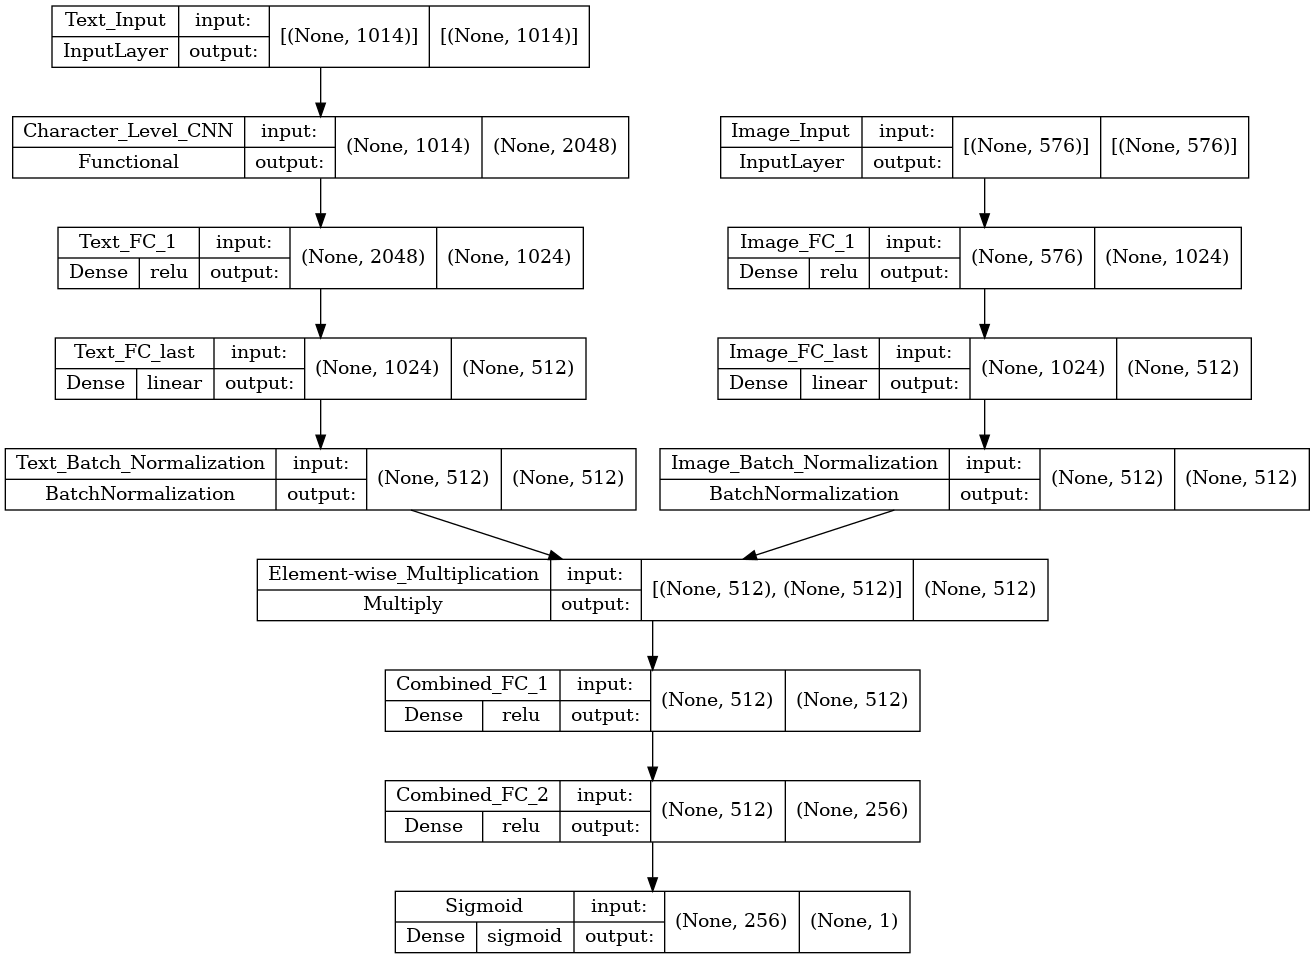

In [56]:
tf.keras.utils.plot_model(mnn_em.model, rankdir="TB", show_layer_activations=True, show_shapes=True)

# Callbacks

In [57]:
from utils.eval import create_callbacks

In [58]:
model_name = config["mnn_em"]["name"]
optimizer_name = config["mnn_em"]["training"]["optimizer"]
learning_rate = config["mnn_em"]["training"]["learning_rate"]

In [59]:
callbacks = create_callbacks(
    callbacks_list=config["mnn_em"]["training"]["callbacks"],
    model_name=model_name,
    img_model_name=img_model.name,
    optimizer_name=optimizer_name,
    learning_rate=learning_rate,
    cls=config["data"]["cls"]
    )

# Training

In [60]:
history = mnn_em.model.fit(
    x=[img_train, text_train],
    y=labels_train,
    epochs=config["mnn_em"]["training"]["epochs"],
    validation_split=config["mnn_em"]["training"]["validation_split"],
    batch_size=config["mnn_em"]["training"]["batch_size"], 
callbacks=callbacks)


Epoch 1/10
7952/7956 [============================>.] - ETA: 0s - loss: 1.0057 - recall: 0.9420 - precision: 0.8724 - binary_accuracy: 0.8909 - cosine_similarity: 0.5570

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


7956/7956 [==============================] - 95s 12ms/step - loss: 1.0053 - recall: 0.9420 - precision: 0.8724 - binary_accuracy: 0.8909 - cosine_similarity: 0.5570 - val_loss: 0.2195 - val_recall: 0.9852 - val_precision: 0.9105 - val_binary_accuracy: 0.9383 - val_cosine_similarity: 0.5526
Epoch 2/10
7953/7956 [============================>.] - ETA: 0s - loss: 0.1871 - recall: 0.9758 - precision: 0.9286 - binary_accuracy: 0.9447 - cosine_similarity: 0.5570

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


7956/7956 [==============================] - 91s 11ms/step - loss: 0.1871 - recall: 0.9758 - precision: 0.9286 - binary_accuracy: 0.9448 - cosine_similarity: 0.5570 - val_loss: 0.1942 - val_recall: 0.9695 - val_precision: 0.9247 - val_binary_accuracy: 0.9396 - val_cosine_similarity: 0.5525
Epoch 3/10
7955/7956 [============================>.] - ETA: 0s - loss: 0.1486 - recall: 0.9815 - precision: 0.9434 - binary_accuracy: 0.9569 - cosine_similarity: 0.5569

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


7956/7956 [==============================] - 94s 12ms/step - loss: 0.1486 - recall: 0.9815 - precision: 0.9434 - binary_accuracy: 0.9569 - cosine_similarity: 0.5569 - val_loss: 0.1572 - val_recall: 0.9679 - val_precision: 0.9519 - val_binary_accuracy: 0.9552 - val_cosine_similarity: 0.5525
Epoch 4/10
7956/7956 [==============================] - 88s 11ms/step - loss: 0.1241 - recall: 0.9835 - precision: 0.9544 - binary_accuracy: 0.9646 - cosine_similarity: 0.5570 - val_loss: 0.1681 - val_recall: 0.9633 - val_precision: 0.9427 - val_binary_accuracy: 0.9473 - val_cosine_similarity: 0.5526
Epoch 5/10
7952/7956 [============================>.] - ETA: 0s - loss: 0.1047 - recall: 0.9855 - precision: 0.9634 - binary_accuracy: 0.9711 - cosine_similarity: 0.5570

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


7956/7956 [==============================] - 104s 13ms/step - loss: 0.1047 - recall: 0.9855 - precision: 0.9634 - binary_accuracy: 0.9711 - cosine_similarity: 0.5570 - val_loss: 0.1318 - val_recall: 0.9848 - val_precision: 0.9487 - val_binary_accuracy: 0.9622 - val_cosine_similarity: 0.5525
Epoch 6/10
7954/7956 [============================>.] - ETA: 0s - loss: 0.0901 - recall: 0.9879 - precision: 0.9694 - binary_accuracy: 0.9759 - cosine_similarity: 0.5570

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


7956/7956 [==============================] - 92s 12ms/step - loss: 0.0901 - recall: 0.9879 - precision: 0.9693 - binary_accuracy: 0.9759 - cosine_similarity: 0.5570 - val_loss: 0.1296 - val_recall: 0.9688 - val_precision: 0.9645 - val_binary_accuracy: 0.9630 - val_cosine_similarity: 0.5525
Epoch 7/10
7956/7956 [==============================] - 87s 11ms/step - loss: 0.0777 - recall: 0.9891 - precision: 0.9748 - binary_accuracy: 0.9797 - cosine_similarity: 0.5570 - val_loss: 0.1346 - val_recall: 0.9878 - val_precision: 0.9546 - val_binary_accuracy: 0.9673 - val_cosine_similarity: 0.5526
Epoch 8/10
7956/7956 [==============================] - 86s 11ms/step - loss: 0.0671 - recall: 0.9900 - precision: 0.9788 - binary_accuracy: 0.9825 - cosine_similarity: 0.5570 - val_loss: 0.1316 - val_recall: 0.9853 - val_precision: 0.9552 - val_binary_accuracy: 0.9663 - val_cosine_similarity: 0.5525
Epoch 9/10
7954/7956 [============================>.] - ETA: 0s - loss: 0.0605 - recall: 0.9909 - precisi

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


7956/7956 [==============================] - 92s 12ms/step - loss: 0.0605 - recall: 0.9909 - precision: 0.9817 - binary_accuracy: 0.9847 - cosine_similarity: 0.5570 - val_loss: 0.1084 - val_recall: 0.9855 - val_precision: 0.9576 - val_binary_accuracy: 0.9679 - val_cosine_similarity: 0.5526
Epoch 10/10
7956/7956 [==============================] - 86s 11ms/step - loss: 0.0545 - recall: 0.9917 - precision: 0.9841 - binary_accuracy: 0.9865 - cosine_similarity: 0.5570 - val_loss: 0.1269 - val_recall: 0.9797 - val_precision: 0.9638 - val_binary_accuracy: 0.9684 - val_cosine_similarity: 0.5525


# Evaluation

## Plot loss and metrics

In [61]:
from utils.eval import plot_metrics

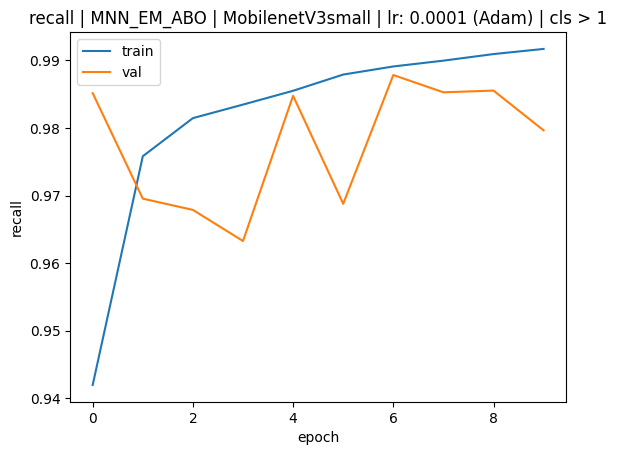

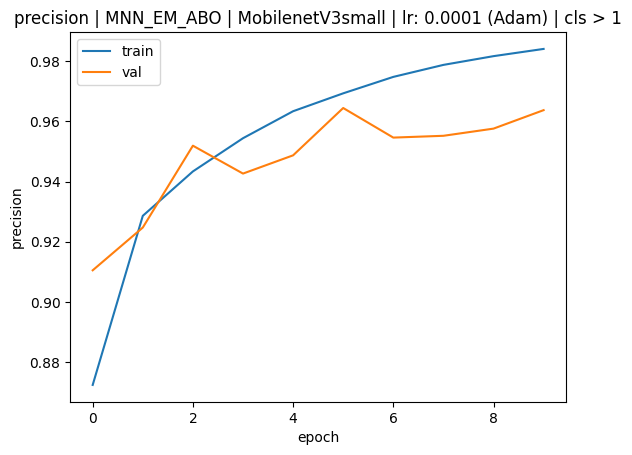

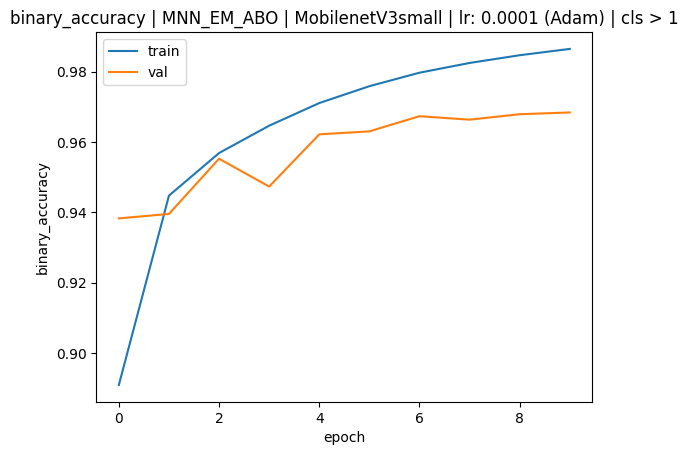

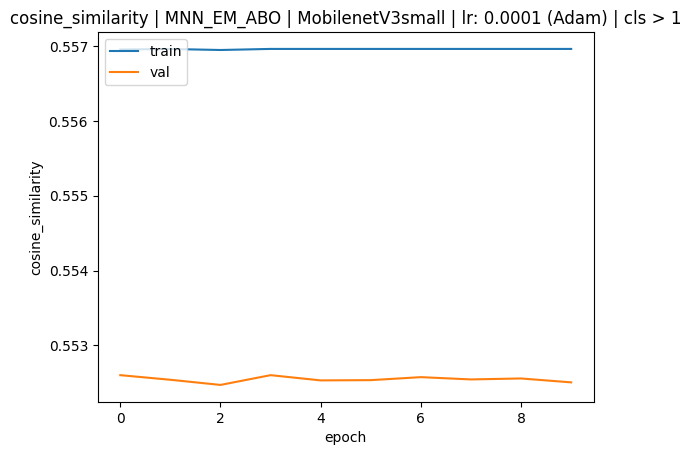

In [62]:
plot_metrics(history.history, config["mnn_em"]["training"]["metrics"], model_name, img_model.name, optimizer_name, learning_rate, config["data"]["cls"])

## Evaluate model and save metrics

In [63]:
from utils.eval import evaluate

In [64]:
evaluate(mnn_em.model, img_test, text_test, labels_test, model_name, img_model.name, optimizer_name, learning_rate, config["data"]["cls"])

15716/15716 [==============================] - 72s 5ms/step - loss: 0.1419 - recall: 0.9772 - precision: 0.9597 - binary_accuracy: 0.9649 - cosine_similarity: 0.5508
